<a href="https://colab.research.google.com/github/todagi/DataAnalysis_skill/blob/master/Scalp_image_VGG16_by_keras__01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VGG16(keras)을 통한 두피이미지 분석**




##   

## **00 관련 패키지 불러오기 및 데이터 준비**

#### **패키지 불러오기**

In [13]:
# 구글 드라이브
from google.colab import drive

# VGG16 분석
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
import numpy as np

# 시각화
import matplotlib.pyplot as plt

##    
#### 구글 드라이브 연동
데이터가 들어있는 본인의 구글 드라이브와 연동한다 

In [1]:
drive.mount('/content/drive')

Mounted at /content/drive


#### **데이터 폴더 경로 지정**

datasets - scalp_small - train/test/validation - scalp_abnormal/scalp_normal

본인 구글 드라이브 폴더에 datasets 폴더를 만들고 준비된 scalp_small 데이터 폴더를 넣는다. 

scalp_small 폴더엔 train, test, validation 폴더가 있고, 각 폴더에는 두피 비정상인 scalp_abnormal과 두피 정상인 scalp_normal이 있다.

In [94]:
# 연동될 폴더 경로를 base_dir로 지정해준다.

base_dir = './drive/MyDrive/datasets/scalp_small/' 


##  

## **01 VGG16 모델 적용 및 학습**

#### **VGG16 모델 불러오기**
Keras 패키지에서 제공하는 VGG16 모델을 불러온다(keras.applications)

사전 훈련된 네트워크를 사용해 새로운 분석할 데이터를 통하시키고 그 출력으로 새로운 분류기를 훈련한다.

In [ ]:
# https://keras.io/api/applications/vgg/#vgg16-function

tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


In [73]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False, 
                  input_shape = (150, 150, 3))



*   weight는 모델을 초기화할 가중치 체크포인트 지정
*   include_top은 네트워크의 최상위 완전 연결 분류기를 포함할지 안할음를 지정하는데 기본값은 ImageNet의 1,000개의 클래스에 대응되는 완전 연결 분류기를 포함. 그러나 여기에선 별도(두피이미지 정상과 비정상)의 완전 연결 층을 추가하기 위해 False 옵션을 준다.






*   input_shape은 네트워크에 주힙할 이미지 텐서의 크기(선택사항). 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리할 수 있음









In [74]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### **이미지로부터 특징을 효과적으로 추출하기(feature extraction)**



*   https://blog.naver.com/PostView.nhn?blogId=syg7949&logNo=221883713196&categoryNo=27&parentCategoryNo=27&from=thumbnailList 참고




두피 이미지 데이터가 있는 디렉토리 경로 지정

In [95]:
train_dir = base_dir + 'train'
validation_dir   = base_dir + 'validation'
test_dir  = base_dir + 'test' 

이미지 특징 추출

In [5]:
datagen = ImageDataGenerator(rescale = 1./255)  # 이미지 스케일 조정 
batch_size = 20

def extract_features(directory, sample_count):

    # features / labels
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))

    # 폴더별로 각 이미지에 자동 라벨링(abnormal/normal)
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = 'binary')
    
    # 특징 추출
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다.
            break
        
    return features, labels

# 특징 추출 함수를 train, validation, test 폴더에 있는 이미지 데이터에 적용한다

train_features, train_labels = extract_features(train_dir, 300)
validation_features, validation_labels = extract_features(validation_dir, 100)
test_features, test_labels = extract_features(test_dir, 100)

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


추출된 특성의 크기는 (samples, 4, 4, 512). 완전 연결 분류기에 주입하기 위해 먼저 (samples, 8192)크기로 펼치기

In [6]:
train_features = np.reshape(train_features, (300, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (100, 4 * 4 * 512))
test_features = np.reshape(test_features, (100, 4 * 4 * 512))

완전 연결 분류기 정의(FCL) 및 훈련

In [33]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
15/15 [==============================] - 1s 25ms/step - loss: 0.7751 - acc: 0.4881 - val_loss: 0.5404 - val_acc: 0.7700
Epoch 2/100
15/15 [==============================] - 0s 17ms/step - loss: 0.5983 - acc: 0.6883 - val_loss: 0.4886 - val_acc: 0.8300
Epoch 3/100
15/15 [==============================] - 0s 18ms/step - loss: 0.5225 - acc: 0.7464 - val_loss: 0.4735 - val_acc: 0.8000
Epoch 4/100
15/15 [==============================] - 0s 17ms/step - loss: 0.5343 - acc: 0.7298 - val_loss: 0.4315 - val_acc: 0.8400
Epoch 5/100
15/15 [==============================] - 0s 16ms/step - loss: 0.5234 - acc: 0.7445 - val_loss: 0.4114 - val_acc: 0.8400
Epoch 6/100
15/15 [==============================] - 0s 17ms/step - loss: 0.4287 - acc: 0.7972 - val_loss: 0.4051 - val_acc: 0.8100
Epoch 7/100
15/15 [==============================] - 0s 17ms/step - loss: 0.4897 - acc: 0.7667 - val_loss: 0.3839 - val_acc: 0.8400
Epoch 8/100
15/15 [==============================] - 0s 17ms/step - loss: 0.

## **02 결과 및 예측**

#### **정확도 손실 그래프 그리기**

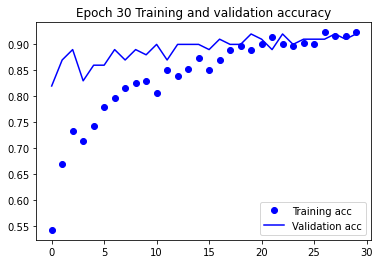

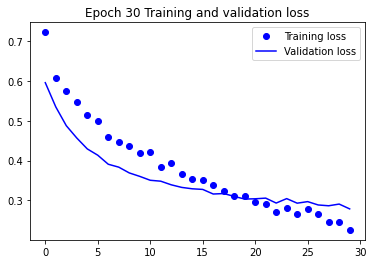

In [14]:
# epochs 30

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Epoch 30 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Epoch 30 Training and validation loss')
plt.legend()

plt.show()

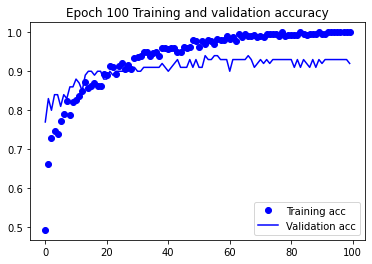

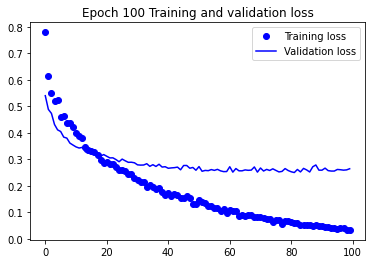

In [34]:
# epoch 100

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Epoch 100 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Epoch 100 Training and validation loss')
plt.legend()

plt.show()

#### **예측**
미리 특징을 추출하고 라벨링까지 끝낸 test_features를 predict 함수를 이용해 예측값을 얻는다

In [77]:
output = model.predict(test_features)
print('갯수: ', len(output))
output[0:10]

갯수:  100


array([[0.99028254],
       [0.99458355],
       [0.99999356],
       [0.11243176],
       [0.14897987],
       [0.8262733 ],
       [0.2923102 ],
       [0.94177824],
       [0.993659  ],
       [0.35671818]], dtype=float32)

In [78]:
print('갯수: ', len(test_labels))
test_labels

갯수:  100


array([1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.])

### 의문 

#### 기본 CNN_keras의 경우 test_generator(test_datagen.flow_from_directory 처리한 값)의 filenames의 구성은 앞에 50장이 abnormal, 뒤에 50장이 normal로 구성되어있다.
####   

#### 그러나 지금 특성추출에서 뽑은 test 데이터들의 labels를 보면 1과 0이 뒤죽박죽으로 되어 있는 것을 볼 수 있다. 앞서 처리할 때 랜덤으로 섞은 것이 아니라면 제대로 라벨링이 되었는지부터가 의문이 된다.
####    

#### 일단 여기에선 제대로 라벨링이 된 것으로 판단하고 test 데이터 예측을 진행하도록 해본다.



---


####   

모델로 예측한 output 값에 대하여 기본 모델에서 가정한 것처럼 

이 값들이 기본이 scalp_abnormal 0인 상태에서 scalp_normal 1이 될 확률이라고 가정

그리고 그 기준인 임계값(Threshold) 0.5로 설정하였다.

In [79]:
# 임계값을 기준에 따라 0과 1 값으로 나눈다

rls = []

for pic in output:
    if pic[0] <= 0.5:
        result = 0
    else:
        result = 1
        
    rls.append(result)
        
len(rls)

100

순서대로 기존에 있던 test_labels 값과 결과값을 임계값 기준으로 나눈 rls 값을 비교해
100개 중 얼마나 일치하는 지를 알아본다.

In [81]:
acc = 0

for i in range(100):
  print(i+1,'번째  실제: ', test_labels[i],' 예측: ', rls[i])
  if test_labels[i] == rls[i]:
    acc += 1

1 번째  실제:  1.0  예측:  1
2 번째  실제:  1.0  예측:  1
3 번째  실제:  1.0  예측:  1
4 번째  실제:  0.0  예측:  0
5 번째  실제:  0.0  예측:  0
6 번째  실제:  0.0  예측:  1
7 번째  실제:  0.0  예측:  0
8 번째  실제:  0.0  예측:  1
9 번째  실제:  1.0  예측:  1
10 번째  실제:  0.0  예측:  0
11 번째  실제:  1.0  예측:  1
12 번째  실제:  0.0  예측:  0
13 번째  실제:  0.0  예측:  0
14 번째  실제:  1.0  예측:  1
15 번째  실제:  1.0  예측:  1
16 번째  실제:  0.0  예측:  0
17 번째  실제:  0.0  예측:  1
18 번째  실제:  0.0  예측:  0
19 번째  실제:  1.0  예측:  1
20 번째  실제:  1.0  예측:  1
21 번째  실제:  1.0  예측:  1
22 번째  실제:  0.0  예측:  0
23 번째  실제:  0.0  예측:  0
24 번째  실제:  0.0  예측:  1
25 번째  실제:  1.0  예측:  1
26 번째  실제:  0.0  예측:  1
27 번째  실제:  0.0  예측:  1
28 번째  실제:  0.0  예측:  0
29 번째  실제:  1.0  예측:  0
30 번째  실제:  0.0  예측:  0
31 번째  실제:  0.0  예측:  0
32 번째  실제:  1.0  예측:  1
33 번째  실제:  1.0  예측:  1
34 번째  실제:  0.0  예측:  0
35 번째  실제:  0.0  예측:  1
36 번째  실제:  0.0  예측:  0
37 번째  실제:  1.0  예측:  0
38 번째  실제:  0.0  예측:  0
39 번째  실제:  1.0  예측:  1
40 번째  실제:  1.0  예측:  1
41 번째  실제:  0.0  예측:  1
42 번째  실제:  0.0  예측:  0
4

#### 일치갯수 정확도

In [82]:
print('예측 결과 100개 중 ', acc, '개가 일치합니다. 정확도: ', acc,'%')

예측 결과 100개 중  80 개가 일치합니다. 정확도:  80 %


#   

## **03 데이터 증식을 사용한 특징 추출 및 VGG16**

#### VGG 모델 및 모델 계측 구성

In [84]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [85]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


합성곱 기반층에 의해 사전에 학습된 표현이 훈련하는 동안 수정되는 것을 막기 위해 

하나 이상의 층을 동결해 가중치가 업데이트 되지 않도록 막는다

In [86]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [87]:
conv_base.trainable = False



  *   2개의 Dense층 가중치만 훈련
  *  층마다 2개씩(가중치 행렬과 편향 벡터) 총 4개의 텐서가 훈련
  *  컴파일 단계 후에 trainable 속성을 변경하면 반드시 모델을 다시 컴파일 해야 한다.



In [88]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


데이터 준비는 위에서 조정한 것을 활용한다.

#### **데이터 증식**

* rescale: 원래 이미지에 입력된 값만큼 이미지의 크기에 곱해서 조율함.

* rotation_range: 지정된 각도 범위에서 임의로 원본 이미지를 회전.

* width_shift_range: 지정된 수평방향 내에서 임의로 원본 이미지를 좌우로 이동.

* height_shift_range: 지정된 수직방향 내에서 임의로 원본 이미지를 상하로 이동.

* brightness_range: 이미지 밝기를 랜덤하게 주는 것.

* horizontal_flip: 수평방향으로 뒤집기

* validation_split: 주어진 데이터셋을 test와 training으로 나누는 비율.

참고: https://chealin93.tistory.com/69

In [89]:
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=20,  
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    fill_mode='nearest')


# Validation, Test 데이터 등 검증 데이터는 증식되어선 안됨
test_datagen = ImageDataGenerator(rescale=1./255)

#### 데이터 라벨링

In [97]:
train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


## **04 학습 및 결과 예측 보기**

#### **모델 컴파일 및 학습**

In [105]:
%%time
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=15,  # total_train // batch_size(300//20)
      epochs=30,
      validation_data=validation_generator,
      validation_steps=5,  # total_val // batch_size (100//20)
      verbose=2)

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/30
15/15 - 51s - loss: 0.4702 - acc: 0.7700 - val_loss: 0.3565 - val_acc: 0.8800
Epoch 2/30
15/15 - 50s - loss: 0.4322 - acc: 0.8133 - val_loss: 0.3507 - val_acc: 0.8700
Epoch 3/30
15/15 - 50s - loss: 0.4206 - acc: 0.8033 - val_loss: 0.3333 - val_acc: 0.8900
Epoch 4/30
15/15 - 50s - loss: 0.4200 - acc: 0.8367 - val_loss: 0.3332 - val_acc: 0.8800
Epoch 5/30
15/15 - 49s - loss: 0.4024 - acc: 0.8367 - val_loss: 0.3178 - val_acc: 0.8700
Epoch 6/30
15/15 - 50s - loss: 0.4013 - acc: 0.8233 - val_loss: 0.3098 - val_acc: 0.9000
Epoch 7/30
15/15 - 50s - loss: 0.3939 - acc: 0.8233 - val_loss: 0.3109 - val_acc: 0.8800
Epoch 8/30
15/15 - 50s - loss: 0.3757 - acc: 0.8433 - val_loss: 0.3119 - val_acc: 0.8700
Epoch 9/30
15/15 - 49s - loss: 0.3846 - acc: 0.8333 - val_loss: 0.3069 - val_acc: 0.8800
Epoch 10/30
15/15 - 49s - loss: 0.3766 - acc: 0.8400 - val_loss: 0.3050 - val_acc: 0.8700
Epoch 11/30
15/15 - 49s - l

#### 정확도 손실 그래프 그리기

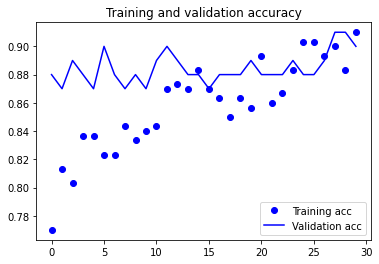

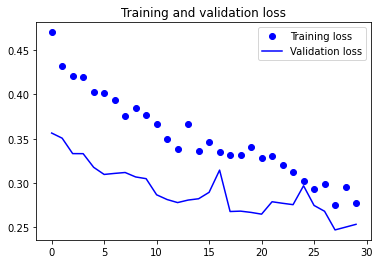

In [106]:
# epoch 30

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


#### **평가 및 예측**

테스트 데이터 라벨링

In [108]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 100 images belonging to 2 classes.


모델평가

In [110]:
%%time

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

50/50 [==============================] - 12s 196ms/step - loss: 0.3582 - acc: 0.8200
test acc: 0.8199999928474426
CPU times: user 23.6 s, sys: 116 ms, total: 23.7 s
Wall time: 12.3 s


 예측

In [111]:
output = model.predict(test_generator)
print('갯수: ', len(output))
output[0:10]

갯수:  100


array([[0.21301913],
       [0.95382786],
       [0.99826205],
       [0.9538845 ],
       [0.11844257],
       [0.9963921 ],
       [0.56402934],
       [0.48029462],
       [0.14325893],
       [0.4125078 ]], dtype=float32)

In [113]:
test_generator.class_indices

{'scalp_abnormal': 0, 'scalp_normal': 1}

In [112]:
test_generator.filenames[45:55]

['scalp_abnormal/scalp_abnormal.245.jpg',
 'scalp_abnormal/scalp_abnormal.246.jpg',
 'scalp_abnormal/scalp_abnormal.247.jpg',
 'scalp_abnormal/scalp_abnormal.248.jpg',
 'scalp_abnormal/scalp_abnormal.249.jpg',
 'scalp_normal/scalp_normal.200.jpg',
 'scalp_normal/scalp_normal.201.jpg',
 'scalp_normal/scalp_normal.202.jpg',
 'scalp_normal/scalp_normal.203.jpg',
 'scalp_normal/scalp_normal.204.jpg']

In [114]:
test_generator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

임계값 설정으로 0(abnoraml), 1(noraml) 판정

In [120]:
# 임계값을 기준에 따라 0과 1 값으로 나눈다

rls = []

for pic in output:
    if pic[0] <= 0.5:
        result = 0
    else:
        result = 1
        
    rls.append(result)
        
print(len(rls))
rls[45:55]

100


[0, 0, 1, 1, 1, 0, 1, 0, 1, 1]

In [127]:
test_generator.labels[45:55]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int32)

In [128]:
acc = 0

for i in range(100):
  print(i+1,'번째  실제: ', test_generator.labels[i],' 예측: ', rls[i])
  if test_generator.labels[i] == rls[i]:
    acc += 1

print(" ")
print('예측 결과 100개 중 ', acc, '개가 일치합니다. 정확도: ', acc,'%')

1 번째  실제:  0  예측:  0
2 번째  실제:  0  예측:  1
3 번째  실제:  0  예측:  1
4 번째  실제:  0  예측:  1
5 번째  실제:  0  예측:  0
6 번째  실제:  0  예측:  1
7 번째  실제:  0  예측:  1
8 번째  실제:  0  예측:  0
9 번째  실제:  0  예측:  0
10 번째  실제:  0  예측:  0
11 번째  실제:  0  예측:  1
12 번째  실제:  0  예측:  1
13 번째  실제:  0  예측:  1
14 번째  실제:  0  예측:  1
15 번째  실제:  0  예측:  0
16 번째  실제:  0  예측:  0
17 번째  실제:  0  예측:  0
18 번째  실제:  0  예측:  0
19 번째  실제:  0  예측:  0
20 번째  실제:  0  예측:  1
21 번째  실제:  0  예측:  1
22 번째  실제:  0  예측:  1
23 번째  실제:  0  예측:  1
24 번째  실제:  0  예측:  0
25 번째  실제:  0  예측:  0
26 번째  실제:  0  예측:  0
27 번째  실제:  0  예측:  1
28 번째  실제:  0  예측:  1
29 번째  실제:  0  예측:  0
30 번째  실제:  0  예측:  0
31 번째  실제:  0  예측:  1
32 번째  실제:  0  예측:  1
33 번째  실제:  0  예측:  0
34 번째  실제:  0  예측:  1
35 번째  실제:  0  예측:  1
36 번째  실제:  0  예측:  1
37 번째  실제:  0  예측:  0
38 번째  실제:  0  예측:  1
39 번째  실제:  0  예측:  0
40 번째  실제:  0  예측:  1
41 번째  실제:  0  예측:  1
42 번째  실제:  0  예측:  1
43 번째  실제:  0  예측:  0
44 번째  실제:  0  예측:  0
45 번째  실제:  0  예측:  0
46 번째  실제:  0  예측: 

####    

## 05 미세 조정

*   모델을 재사용하는 데 널리 사용되고, 특성 추출을 보완하는 또 하나의 기법
*   미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제
*   네트워크 미세 조정 단계
   
    01 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가합니다.

    02 기반 네트워크를 동결합니다.

    03 새로 추가한 네트워크를 훈련합니다.

    04 기반 네트워크에서 일부 층의 동결을 해제합니다.

    05 동결을 해제한 층과 새로 추가한 층을 함께 훈련합니다.

    





사전에 훈련된 VGG16 네트워크 보기

In [138]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### **마지막 세 개의 합성곱 층을 미세 조정하겠습니다.** 
#### **즉, block4_pool까지 모든 층은 동결되고 block5_conv1, block5_conv2, block5_conv3 층은 학습 대상**

In [151]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

#### 모델 컴파일 및 학습

In [154]:
%%time

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])


history = model.fit(
      train_generator,
      steps_per_epoch=15,  # total_train // batch_size (300//20)
      epochs=30,  # 50
      validation_data=validation_generator,
      validation_steps=5,  # total_val // batch_size (100//20)
      verbose=2)

Epoch 1/30
15/15 - 60s - loss: 0.2577 - acc: 0.8867 - val_loss: 0.2134 - val_acc: 0.9300
Epoch 2/30
15/15 - 59s - loss: 0.2336 - acc: 0.9167 - val_loss: 0.2909 - val_acc: 0.8800
Epoch 3/30
15/15 - 59s - loss: 0.2009 - acc: 0.9300 - val_loss: 0.2887 - val_acc: 0.8600
Epoch 4/30
15/15 - 59s - loss: 0.1908 - acc: 0.9367 - val_loss: 0.1957 - val_acc: 0.9300
Epoch 5/30
15/15 - 59s - loss: 0.1750 - acc: 0.9200 - val_loss: 0.2015 - val_acc: 0.9300
Epoch 6/30
15/15 - 59s - loss: 0.1681 - acc: 0.9500 - val_loss: 0.1837 - val_acc: 0.9200
Epoch 7/30
15/15 - 59s - loss: 0.1848 - acc: 0.9233 - val_loss: 0.2192 - val_acc: 0.9100
Epoch 8/30
15/15 - 59s - loss: 0.1633 - acc: 0.9333 - val_loss: 0.1933 - val_acc: 0.9300
Epoch 9/30
15/15 - 59s - loss: 0.1426 - acc: 0.9500 - val_loss: 0.1785 - val_acc: 0.9200
Epoch 10/30
15/15 - 59s - loss: 0.1273 - acc: 0.9667 - val_loss: 0.2050 - val_acc: 0.9100
Epoch 11/30
15/15 - 59s - loss: 0.1294 - acc: 0.9700 - val_loss: 0.2194 - val_acc: 0.9100
Epoch 12/30
15/15 -

#### **모델저장**

In [166]:
model.save('scalp_VGG16_FT_epc30.h5')

# /content/scalp_VGG16_FT_epc30.h5

#### 정확도 손실도 그래프 그리기

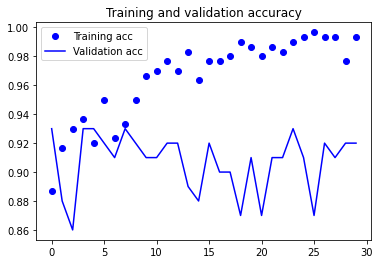

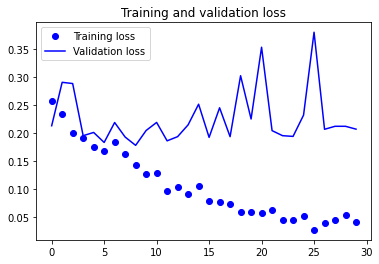

In [155]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 평가

In [157]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 100 images belonging to 2 classes.
50/50 [==============================] - 12s 198ms/step - loss: 0.3436 - acc: 0.8500
test acc: 0.8500000238418579


미세조정 하기 전보다 4약 4% 정도 증가

#### 예측

In [158]:
output = model.predict(test_generator)
print('갯수: ', len(output))
output[0:10]

갯수:  100


array([[0.00945675],
       [0.9944307 ],
       [0.0105662 ],
       [0.12250867],
       [0.49325895],
       [0.78627086],
       [0.97941244],
       [0.9700979 ],
       [0.2757907 ],
       [0.06386337]], dtype=float32)

In [159]:
test_generator.class_indices

{'scalp_abnormal': 0, 'scalp_normal': 1}

In [160]:
test_generator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [164]:
rls = []

for pic in output:
    if pic[0] <= 0.5:
        result = 0
    else:
        result = 1
        
    rls.append(result)
        
print(len(rls))
rls[45:55]

100


[0, 0, 1, 1, 1, 0, 0, 1, 0, 0]

In [165]:
acc = 0

for i in range(100):
  # print(i+1,'번째  실제: ', test_generator.labels[i],' 예측: ', rls[i])
  if test_generator.labels[i] == rls[i]:
    acc += 1

print(" ")
print('예측 결과 100개 중 ', acc, '개가 일치합니다. 정확도: ', acc,'%')

 
예측 결과 100개 중  49 개가 일치합니다. 정확도:  49 %


예측 정확도는 조금 낮아짐